In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import altair as alt
alt.data_transformers.enable('json')
import datetime as dt
import numpy as np
from metpy.units import units
import pandas as pd
import rioxarray as rix
import geopandas as gpd
from shapely.geometry import LineString
import pint_xarray
from sublimpy import variables, utils, tidy

Open the SOS tidy dataset

In [2]:
sos_tidy_fn = f"../../paper1/process_slow_data/tidy_df_20221101_20230619_planar_fit_multiplane_q7_flags9000_pf10.parquet"
sos_df = pd.read_parquet(sos_tidy_fn)
sos_df['time'] = pd.to_datetime(sos_df['time'])
sos_df = utils.modify_df_timezone(sos_df, 'UTC', 'US/Mountain')

# Open and prepare data

Set all file paths

In [3]:
fn_l2 = "/Users/elischwat/Development/data/sublimationofsnow/lidar_rasters/l2_test_20230505_20230530_hourly.nc"
fn_l6 = "/Users/elischwat/Development/data/sublimationofsnow/lidar_rasters/l6_test_20230505_20230530_hourly.nc"
towers_location_fn = "../landsat_data/towers.geojson"
profile_lines_fn = "/Users/elischwat/Downloads/snow_patch_profiles.shp"

In [4]:
ds_l2_lazy = xr.open_dataset(fn_l2, chunks={'time': 100, 'x': 100, 'y':100}).sel(time=slice('20230510', '20230525'))
ds_l6_lazy = xr.open_dataset(fn_l6, chunks={'time': 100, 'x': 100, 'y':100}).sel(time=slice('20230510', '20230525'))

Georeference the lidar datasets

In [5]:
towers_gdf = gpd.read_file(towers_location_fn)
towers_gdf = towers_gdf.to_crs("EPSG:32613")

In [6]:
ds_l2_lazy = ds_l2_lazy.assign_coords(
    x = ds_l2_lazy.x + towers_gdf.set_index('Tower').loc['c']['geometry'].x,
    y = ds_l2_lazy.y + towers_gdf.set_index('Tower').loc['c']['geometry'].y
).rio.write_crs(towers_gdf.crs)
ds_l6_lazy = ds_l6_lazy.assign_coords(
    x = ds_l6_lazy.x + towers_gdf.set_index('Tower').loc['c']['geometry'].x,
    y = ds_l6_lazy.y + towers_gdf.set_index('Tower').loc['c']['geometry'].y
).rio.write_crs(towers_gdf.crs)

Open profile lines

In [7]:
profile_lines_gdf = gpd.read_file(profile_lines_fn)
def increase_line_resolution(line, resolution=0.2):    
    line_length = line.length

    # Generate points along the LineString at intervals of 0.1 units
    num_points = int(line_length / resolution) + 1
    generated_points = [line.interpolate(i*resolution) for i in range(num_points)]
    return LineString(generated_points)

profile_lines_gdf.geometry = profile_lines_gdf.geometry.apply(increase_line_resolution)

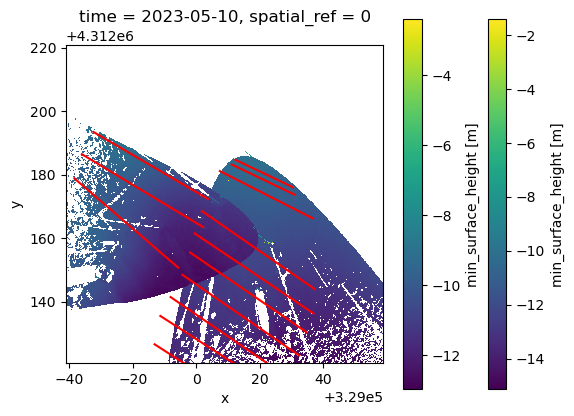

In [8]:
profile_lines_gdf.plot(color='red')
ds_l2_lazy.isel(time=0).surface.plot()
ds_l6_lazy.isel(time=0).surface.plot()

We know we want these profiles: [0, 1, 2, 4, 5, 8]

In [9]:
profile_lines_gdf = profile_lines_gdf.iloc[[0, 1, 2, 4, 5, 8]]

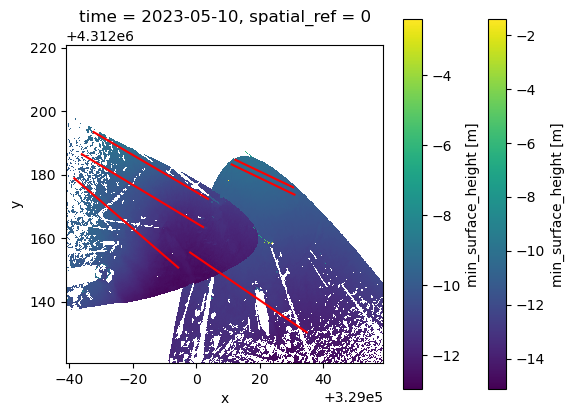

In [10]:
profile_lines_gdf.plot(color='red')
ds_l2_lazy.isel(time=0).surface.plot()
ds_l6_lazy.isel(time=0).surface.plot()


In [11]:
profile_df_list = []
for i, row in profile_lines_gdf.iterrows():
    geom = row['geometry']
    if row['patch'] == 'd':
        ds_to_sample = ds_l2_lazy
    elif row['patch'] == 'uw':
        ds_to_sample = ds_l6_lazy
    
    # Create a list to store the results
    nearest_values = []

    # Iterate over each coordinate
    first_coord = geom.coords[0]
    for x, y in geom.coords:
        distance_from_first_coord = np.sqrt((x - first_coord[0])**2 + (y - first_coord[1])**2) 
        # Extract the nearest value from ds_l2_lazy
        nearest_value = ds_to_sample.surface.sel(x=x, y=y, method='nearest').compute()
        nearest_values.append({'x': x, 'y': y, 'nearest_value': nearest_value, 'distance': distance_from_first_coord})

    # Convert the results to a DataFrame
    nearest_values_df = pd.DataFrame(nearest_values)

    df = pd.concat(nearest_values_df.apply(
        lambda row: row['nearest_value'].to_dataframe().assign(x = row['x'], y = row['y'], distance=row['distance']),
        axis = 1
    ).to_list())
    df = df.assign(patch = str(row['patch']) + '_' + str(row['id']))
    profile_df_list.append(df)

In [12]:
def chart(src):
    src_snow = src[src.index.day.isin([10, 11, 12, 13,14,15,16,17,18])]
    src_ground = src[src.index.day == 25]
    chart_ground = alt.Chart(src_ground.dropna().reset_index()).mark_line(
        color='#341C02'
    ).encode(
        alt.X('distance:Q'),
        alt.Y('mean(surface):Q').scale(zero=False),
    ).properties(height=150)
    chart_snow = alt.Chart(src_snow.dropna().reset_index()).mark_line().encode(
        alt.X('distance:Q'),
        alt.Y('mean(surface):Q').scale(zero=False),
        alt.Color('date(time):O'),
        tooltip = 'date(time)',
        # tooltip = 'distance',
    ).properties(height=150)
    return chart_snow + chart_ground

In [13]:
(chart(profile_df_list[0]) | chart(profile_df_list[1]) | chart(profile_df_list[2])) &\
(chart(profile_df_list[3]) | chart(profile_df_list[4]) | chart(profile_df_list[5]))

alt.VConcatChart(...)

Examine ablation rates (normalized) as a function of distance from the leading edge this is seriously imperfect b/c we don't really know where the leading edge is, and we don't appropriately deal with the fact that the ground is becoming exposed throughout or time period, plus there is error in the lidar measurements due to all of that

Do it manually, reseting the starting position each day

for profile #1

In [14]:
src = profile_df_list[1]
src = src[src.index.hour == 0]
src = src[src.index.day.isin([10,11,12,13,14,15,16,17,18,25])]
alt.Chart(src.reset_index()).mark_line().encode(
    alt.X('distance:Q'),
    alt.Y('mean(surface):Q').scale(zero=False),
    alt.Color('date(time):O').scale(scheme='turbo'),
    tooltip='date(time):O'
).properties(width=1000)

alt.Chart(...)

In [15]:
# for each day, we determined where the new "windward toe" was, and subtract that distance value
# so that each day has "distance" relative to the actual location of the snow patch edge
df_10 = profile_df_list[1].loc['20230510'].query("distance <= 35")
df_10 = df_10.assign(distance = df_10.distance - 5).query("distance > 0")

df_11 = profile_df_list[1].loc['20230511'].query("distance <= 35")
df_11 = df_11.assign(distance = df_11.distance - 5).query("distance > 0")

df_12 = profile_df_list[1].loc['20230512'].query("distance <= 35")
df_12 = df_12.assign(distance = df_12.distance - 6).query("distance > 0")

df_13 = profile_df_list[1].loc['20230513'].query("distance <= 35")
df_13 = df_13.assign(distance = df_13.distance - 7).query("distance > 0")

df_14 = profile_df_list[1].loc['20230514'].query("distance <= 35")
df_14 = df_14.assign(distance = df_14.distance - 8).query("distance > 0")

df_15 = profile_df_list[1].loc['20230515'].query("distance <= 35")
df_15 = df_15.assign(distance = df_15.distance - 11).query("distance > 0")

df_16 = profile_df_list[1].loc['20230516'].query("distance <= 35")
df_16 = df_16.assign(distance = df_16.distance - 13).query("distance > 0")

df_17 = profile_df_list[1].loc['20230517'].query("distance <= 35")
df_17 = df_17.assign(distance = df_17.distance - 15).query("distance > 0")

df_18 = profile_df_list[1].loc['20230518'].query("distance <= 35")
df_18 = df_18.assign(distance = df_18.distance - 19).query("distance > 0")

In [16]:
combined_adjusted_profiles = pd.concat([df_10, df_11, df_12, df_13, df_14, df_15, df_16, df_17, df_18])
ds = combined_adjusted_profiles.reset_index().set_index(['time', 'distance', 'patch'])['surface'].to_xarray()
ds = ds.differentiate('time', datetime_unit='h') 
df_patch1 = ds.to_dataframe().reset_index()[['distance', 'surface', 'time']]
df_patch1['bin'] = pd.cut(df_patch1.distance, 12).apply(lambda interval: float((interval.left + interval.right)/2)).astype(float)

for profile #0

In [17]:
src = profile_df_list[0]
src = src[src.index.hour == 0]
src = src[src.index.day.isin([10,11,12,13,14,15,16,17,18,25])]
display(alt.Chart(src.reset_index()).mark_line().encode(
    alt.X('distance:Q'),
    alt.Y('mean(surface):Q').scale(zero=False),
    alt.Color('date(time):O').scale(scheme='turbo'),
    tooltip='date(time):O'
).properties(width=1000))
# for each day, we determined where the new "windward toe" was, and subtract that distance value
# so that each day has "distance" relative to the actual location of the snow patch edge
df_10 = profile_df_list[0].loc['20230510'].query("distance <= 35")
df_10 = df_10.assign(distance = df_10.distance - 6).query("distance > 0")

df_11 = profile_df_list[0].loc['20230511'].query("distance <= 35")
df_11 = df_11.assign(distance = df_11.distance - 6).query("distance > 0")

df_12 = profile_df_list[0].loc['20230512'].query("distance <= 35")
df_12 = df_12.assign(distance = df_12.distance - 6).query("distance > 0")

df_13 = profile_df_list[0].loc['20230513'].query("distance <= 35")
df_13 = df_13.assign(distance = df_13.distance - 7).query("distance > 0")

df_14 = profile_df_list[0].loc['20230514'].query("distance <= 35")
df_14 = df_14.assign(distance = df_14.distance - 7).query("distance > 0")

df_15 = profile_df_list[0].loc['20230515'].query("distance <= 35")
df_15 = df_15.assign(distance = df_15.distance - 10).query("distance > 0")

df_16 = profile_df_list[0].loc['20230516'].query("distance <= 35")
df_16 = df_16.assign(distance = df_16.distance - 11).query("distance > 0")

df_17 = profile_df_list[0].loc['20230517'].query("distance <= 35")
df_17 = df_17.assign(distance = df_17.distance - 12).query("distance > 0")

df_18 = profile_df_list[0].loc['20230518'].query("distance <= 35")
df_18 = df_18.assign(distance = df_18.distance - 15).query("distance > 0")

alt.Chart(...)

In [18]:
combined_adjusted_profiles = pd.concat([df_10, df_11, df_12, df_13, df_14, df_15, df_16, df_17])
ds = combined_adjusted_profiles.reset_index().set_index(['time', 'distance', 'patch'])['surface'].to_xarray()
ds = ds.differentiate('time', datetime_unit='h') 
df_patch0 = ds.to_dataframe().reset_index()[['distance', 'surface', 'time']]
df_patch0['bin'] = pd.cut(df_patch0.distance, 12).apply(lambda interval: float((interval.left + interval.right)/2)).astype(float)

In [19]:
def get_chart(src):
    return (
        alt.Chart(src).mark_errorbar(extent='ci').encode(
            alt.X('bin:Q'), 
            alt.Y('surface:Q').scale(zero=False),
            alt.Color('patch:N')
        ).properties(height=150)
        + 
        alt.Chart(src).mark_circle(color='black').encode(
            alt.X('bin:Q'), 
            alt.Y('mean(surface):Q').scale(zero=False),
            alt.Color('patch:N')
        ).properties(height=150)
        +
        alt.Chart(src).mark_line(color='black').encode(
            alt.X('bin:Q'), 
            alt.Y('mean(surface):Q').scale(zero=False),
            alt.Color('patch:N')
        ).properties(height=150)
        +
        alt.Chart(pd.DataFrame({'y': [1]})).mark_rule(color='black').encode(
            alt.Y('y:Q')
        )
    )

In [20]:
df_patch0_normed = df_patch0.assign(surface = df_patch0.surface / df_patch0.surface.mean())
df_patch1_normed = df_patch1.assign(surface = df_patch1.surface / df_patch1.surface.mean())
src = pd.concat([df_patch0_normed.assign(patch=0),df_patch1_normed.assign(patch=1)])
get_chart(src)

alt.LayerChart(...)

Separate by wind direction times

In [21]:
# filter to only include times during downvalley-ish winds
wind_dir_src = sos_df[sos_df.variable.isin([
    'dir_3m_c',
    'dir_5m_c',
    'dir_20m_c',
])]
wind_dir_src = wind_dir_src[wind_dir_src.time > '20230509']
wind_dir_src = wind_dir_src[wind_dir_src.time < '20230524']
down_valley_wind_times = wind_dir_src[wind_dir_src.value > 250][wind_dir_src.value < 360].query("variable == 'dir_3m_c'").time

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_35962/1148964861.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  down_valley_wind_times = wind_dir_src[wind_dir_src.value > 250][wind_dir_src.value < 360].query("variable == 'dir_3m_c'").time


In [22]:
# Calculated normalized surface change rates, but only include times during downvalley winds
df_patch0_dv_winds = df_patch0[df_patch0.time.isin(down_valley_wind_times)]
df_patch1_dv_winds = df_patch1[df_patch1.time.isin(down_valley_wind_times)]
df_patch0_dv_winds_normed = df_patch0_dv_winds.assign(surface = df_patch0_dv_winds.surface / df_patch0_dv_winds.surface.mean())
df_patch1_dv_winds_normed = df_patch1_dv_winds.assign(surface = df_patch1_dv_winds.surface / df_patch1_dv_winds.surface.mean())
src_dv_winds = pd.concat([df_patch0_dv_winds_normed.assign(patch=0),df_patch1_dv_winds_normed.assign(patch=1)])

# ...same... upvalley winds
df_patch0_uv_winds = df_patch0[~df_patch0.time.isin(down_valley_wind_times)]
df_patch1_uv_winds = df_patch1[~df_patch1.time.isin(down_valley_wind_times)]
df_patch0_uv_winds_normed = df_patch0_uv_winds.assign(surface = df_patch0_uv_winds.surface / df_patch0_uv_winds.surface.mean())
df_patch1_uv_winds_normed = df_patch1_uv_winds.assign(surface = df_patch1_uv_winds.surface / df_patch1_uv_winds.surface.mean())
src_uv_winds = pd.concat([df_patch0_uv_winds_normed.assign(patch=0),df_patch1_uv_winds_normed.assign(patch=1)])

In [23]:
get_chart(src_dv_winds) | get_chart(src_uv_winds)

alt.HConcatChart(...)

# Calculate Lidar-based melt rates

1. Only include data points (distance values) where we know melt occurred on all the days of interest. We use the plots above to determine the range in distance values to include.
2. Apply an accumulating minimum filter - which removes positive SWE signals
3. Calculate daily/hourly ∆SWE (difference the datasets time-wise)
4. Calculate the mean

In [24]:
# 1. Only include data points (distance values) where we know melt occurred
patch_uw_profile_1 = profile_df_list[0].reset_index().set_index(['time', 'distance', 'patch'])['surface'].to_xarray().sel(distance = slice(15,30))
patch_uw_profile_2 = profile_df_list[1].reset_index().set_index(['time', 'distance', 'patch'])['surface'].to_xarray().sel(distance = slice(20, 33))
patch_uw_profile_3 = profile_df_list[2].reset_index().set_index(['time', 'distance', 'patch'])['surface'].to_xarray().sel(distance = slice(17.5, 35))
patch_d_profile_1 = profile_df_list[3].reset_index().set_index(['time', 'distance', 'patch'])['surface'].to_xarray().sel(distance = slice(12, 20))
patch_d_profile_2 = profile_df_list[4].reset_index().set_index(['time', 'distance', 'patch'])['surface'].to_xarray().sel(distance = slice(10, 18))
patch_d_profile_3 = profile_df_list[5].reset_index().set_index(['time', 'distance', 'patch'])['surface'].to_xarray().sel(distance = slice(22.5, 35))

In [25]:
profile_ds_list = [
    patch_uw_profile_1.sel(time = slice('20230510', '20230518')),
    patch_uw_profile_2.sel(time = slice('20230510', '20230518')),
    patch_uw_profile_3.sel(time = slice('20230510', '20230518')),
    patch_d_profile_1.sel(time = slice('20230510', '20230518')),
    patch_d_profile_2.sel(time = slice('20230510', '20230518')),
    patch_d_profile_3.sel(time = slice('20230510', '20230518')),
]

In [26]:
# 2. Apply an accumulating minimum filter - which removes positive SWE signals
for i, ds in enumerate(profile_ds_list):
    profile_ds_list[i] = ds.copy(data = np.minimum.accumulate(ds.values, axis=0))

In [27]:
# 3. Calculate hourly and daily change rates
diff_hourly_ds_list = []
diff_daily_ds_list = []
for i, ds in enumerate(profile_ds_list):
    diff_hourly_ds_list.append( ds.differentiate('time', datetime_unit='h') )
    diff_daily_ds_list.append( ds.sel(time = slice(None, None, 24)).differentiate('time', datetime_unit='h') )

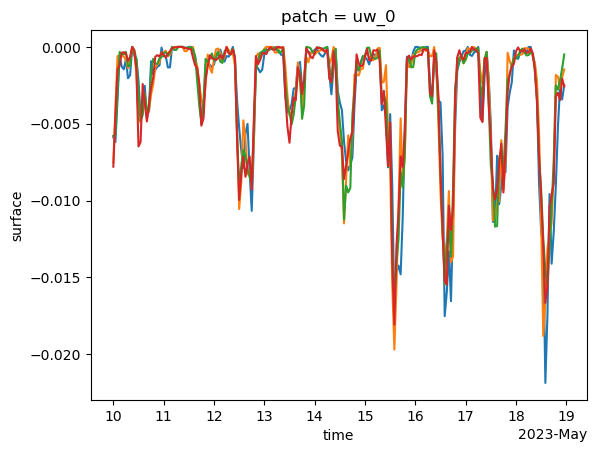

In [28]:
diff_hourly_ds_list[0].isel(distance=slice(0,20)).mean('distance').plot()

diff_hourly_ds_list[0].isel(distance=slice(20,40)).mean('distance').plot()

diff_hourly_ds_list[0].isel(distance=slice(40,60)).mean('distance').plot()
diff_hourly_ds_list[0].isel(distance=slice(60,80)).mean('distance').plot()

In [29]:
# 4. Calculate the profile-averaged hourly and daily change rates 
mean_diff_hourly_ds_list = []
mean_diff_daily_ds_list = []

for i, ds in enumerate(diff_hourly_ds_list):
    mean_diff_hourly_ds_list.append(ds.mean('distance'))

for i, ds in enumerate(diff_daily_ds_list):
    mean_diff_daily_ds_list.append(ds.mean('distance'))

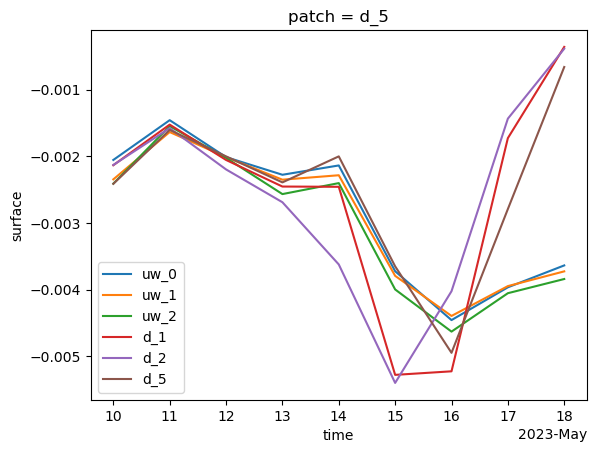

In [30]:
for ds in mean_diff_daily_ds_list:
    ds.plot(label = ds.patch.values)
plt.legend()
plt.show()

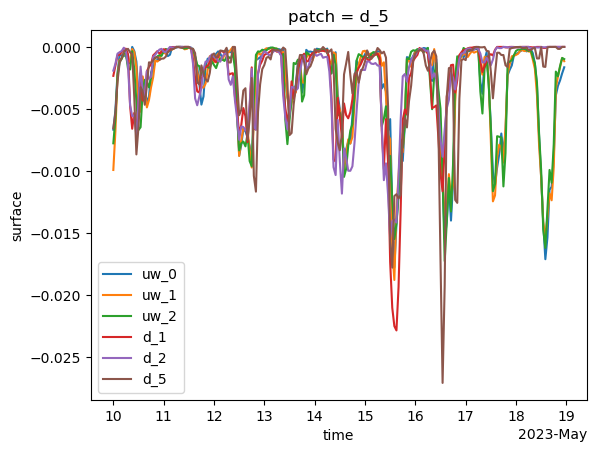

In [31]:
for ds in mean_diff_hourly_ds_list:
    ds.plot(label = ds.patch.values)
plt.legend()
plt.show()

Convert to W/m^2

In [32]:
snow_density = 400 * units("kg/m^3")
specific_heat_of_fusion = 334 * units("kJ/kg")

In [33]:
emelt_daily_ds_list = []
for ds in mean_diff_daily_ds_list:
    emelt_daily_ds_list.append((
        (
            (
                ds / (60*60*24)
            ) * units("m^3/s") * snow_density * specific_heat_of_fusion
        ) / (1*units("m^2"))
    ).pint.to("W/m^2"))



emelt_hourly_ds_list = []
for ds in mean_diff_hourly_ds_list:
    emelt_hourly_ds_list.append((
        (
            (
                ds / (60*60)
            ) * units("m^3/s") * snow_density * specific_heat_of_fusion
        ) / (1*units("m^2"))
    ).pint.to("W/m^2"))

Plot: daily-averaged melt energy, using 24-hr timesteps in lidar data (e.g. use every 24th scan)

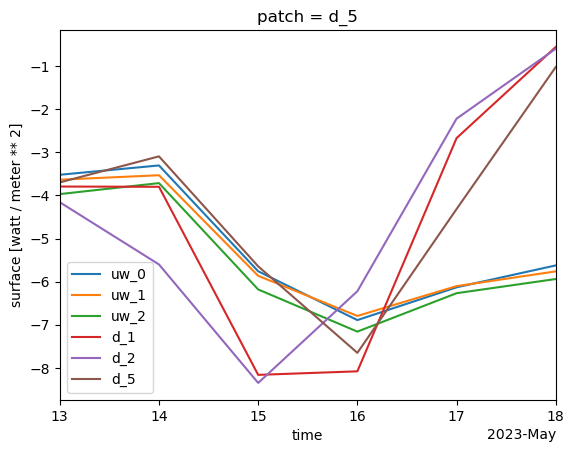

In [34]:
for ds in emelt_daily_ds_list:
    ds.plot(label = ds.patch.values)
plt.legend()
plt.xlim(dt.datetime(2023, 5, 13), dt.datetime(2023, 5, 18))
plt.show()

Plot: daily-averaged melt energy, aggregated from hourly-averaged melt energy, from 1-hr timesteps in lidar data (e.g. use every scan)

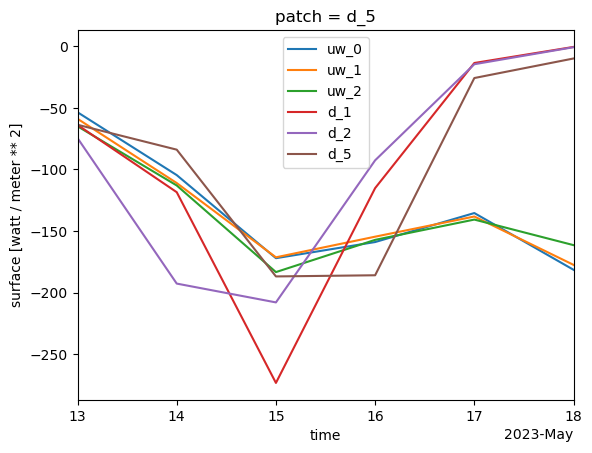

In [35]:
for ds in emelt_hourly_ds_list:
    ds.resample(time='24h').mean().plot(label = ds.patch.values)
plt.legend()
plt.xlim(dt.datetime(2023, 5, 13), dt.datetime(2023, 5, 18))
plt.show()

Plot: hourly-averaged melt energy, from 1-hr timesteps in lidar data (e.g. use every scan)

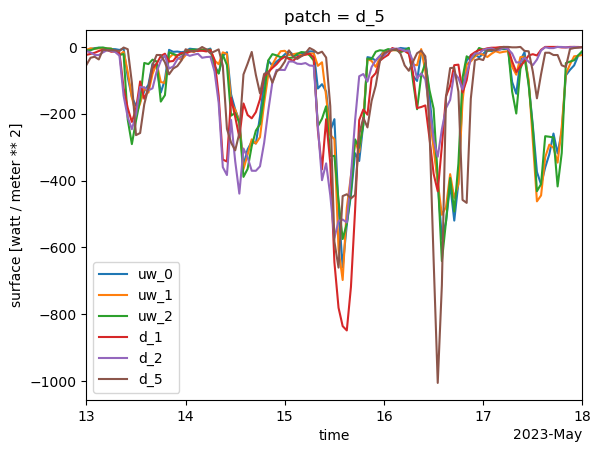

In [36]:
for ds in emelt_hourly_ds_list:
    ds.plot(label = ds.patch.values)
plt.legend()
plt.xlim(dt.datetime(2023, 5, 13), dt.datetime(2023, 5, 18))
plt.show()

# Energy balance calculations

## Gather data - SOS and SPLASH measurements


Note that the SOS radiometers were down in the middle of our study period. So we get radiometrics from the SPLASH KPS ANNEX site.

Note that the SOS dataset is missing radiation measurements during our study period

<Axes: xlabel='time'>

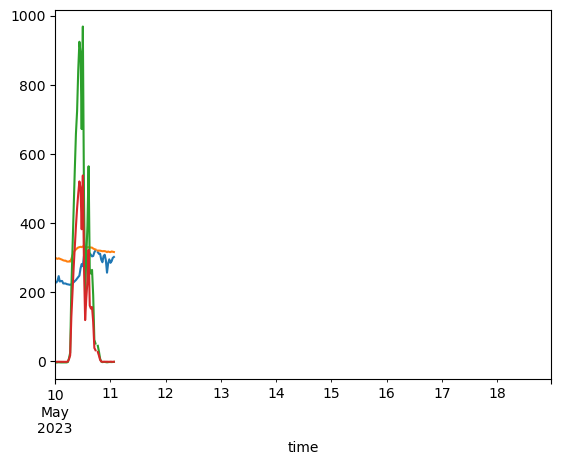

In [37]:
sos_df.query("variable == 'Rlw_in_9m_d'").set_index('time').sort_index().loc['20230510': '20230518'].value.plot()
sos_df.query("variable == 'Rlw_out_9m_d'").set_index('time').sort_index().loc['20230510': '20230518'].value.plot()
sos_df.query("variable == 'Rsw_in_9m_d'").set_index('time').sort_index().loc['20230510': '20230518'].value.plot()
sos_df.query("variable == 'Rsw_out_9m_d'").set_index('time').sort_index().loc['20230510': '20230518'].value.plot()

Open the SPLASH dataset

In [38]:
kps_download_dir = "/Users/elischwat/Development/data/sublimationofsnow/asfs/ASFS-30_Level2_SPLASH2021-2023/"
kps_file_list = sorted([
    os.path.join(kps_download_dir, f) for f in os.listdir(kps_download_dir) 
    if 'sledseb.asfs30.level2.0.10min.' in f
])[385:]
kps_file_list = [f for f in kps_file_list if f[-18:-10] in 
    [
        '20230508', '20230509', '20230510', '20230511', '20230512', '20230513', 
        '20230514', '20230515', '20230516', '20230517', '20230518', '20230519', 
        '20230520', '20230521', '20230522', '20230523', '20230524', '20230525'    
    ]
]
kpsann_ds = xr.open_mfdataset(kps_file_list)
kpsann_df = kpsann_ds[[
    'time', 'temp', 'atmos_pressure',  'skin_temp_surface',
    'down_long_hemisp', 'up_long_hemisp', 'down_short_hemisp', 'up_short_hemisp',
]].to_dataframe()
kpsann_df_30min = kpsann_df.reset_index().set_index('time').resample('30min').mean()

Check SPLASH has all four radiation terms for our study period

<Axes: xlabel='time'>

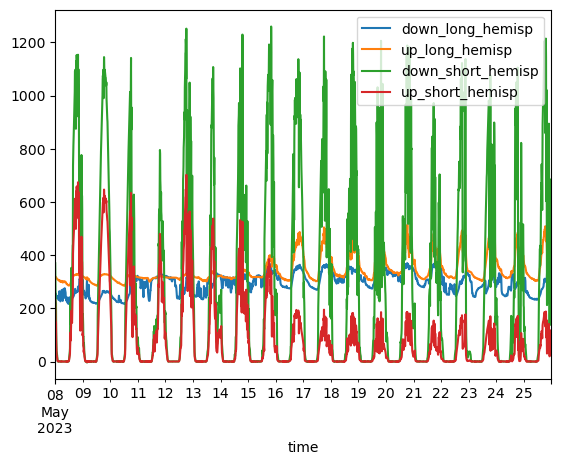

In [39]:
kpsann_df[[
    'down_long_hemisp', 'up_long_hemisp', 'down_short_hemisp', 'up_short_hemisp',
]].plot()

Gather the 5min SOS datasets. Use radiation measurements from the 5min SOS datasets, along with the SPLASH datasets, to ensure we have complete radiometric measurements in one dataset, representing Kettle Ponds area.

<Axes: xlabel='time'>

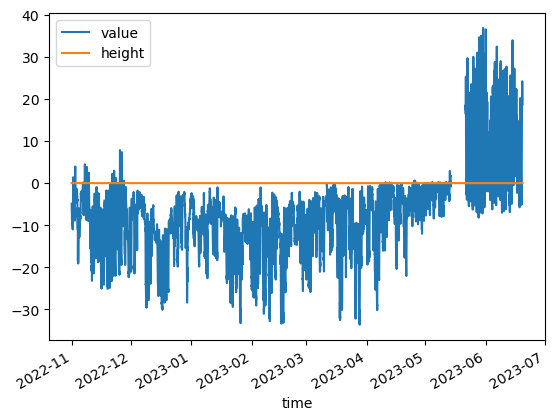

In [40]:
sos_df.query("variable == 'Tsurf_c'").set_index('time').plot()

In [41]:
# open up SOS 5min datasets
files = [
    "/Users/elischwat/Development/data/sublimationofsnow/sosqc/sos_isfs_qc_geo_tiltcor_5min_v20241227/isfs_sos_qc_geo_tiltcor_5min_v2_20230508.nc",
    "/Users/elischwat/Development/data/sublimationofsnow/sosqc/sos_isfs_qc_geo_tiltcor_5min_v20241227/isfs_sos_qc_geo_tiltcor_5min_v2_20230509.nc",
    "/Users/elischwat/Development/data/sublimationofsnow/sosqc/sos_isfs_qc_geo_tiltcor_5min_v20241227/isfs_sos_qc_geo_tiltcor_5min_v2_20230510.nc",
    "/Users/elischwat/Development/data/sublimationofsnow/sosqc/sos_isfs_qc_geo_tiltcor_5min_v20241227/isfs_sos_qc_geo_tiltcor_5min_v2_20230511.nc",
    "/Users/elischwat/Development/data/sublimationofsnow/sosqc/sos_isfs_qc_geo_tiltcor_5min_v20241227/isfs_sos_qc_geo_tiltcor_5min_v2_20230512.nc",
    "/Users/elischwat/Development/data/sublimationofsnow/sosqc/sos_isfs_qc_geo_tiltcor_5min_v20241227/isfs_sos_qc_geo_tiltcor_5min_v2_20230513.nc",
    "/Users/elischwat/Development/data/sublimationofsnow/sosqc/sos_isfs_qc_geo_tiltcor_5min_v20241227/isfs_sos_qc_geo_tiltcor_5min_v2_20230514.nc",
    "/Users/elischwat/Development/data/sublimationofsnow/sosqc/sos_isfs_qc_geo_tiltcor_5min_v20241227/isfs_sos_qc_geo_tiltcor_5min_v2_20230515.nc",
    "/Users/elischwat/Development/data/sublimationofsnow/sosqc/sos_isfs_qc_geo_tiltcor_5min_v20241227/isfs_sos_qc_geo_tiltcor_5min_v2_20230516.nc",
    "/Users/elischwat/Development/data/sublimationofsnow/sosqc/sos_isfs_qc_geo_tiltcor_5min_v20241227/isfs_sos_qc_geo_tiltcor_5min_v2_20230517.nc",
    "/Users/elischwat/Development/data/sublimationofsnow/sosqc/sos_isfs_qc_geo_tiltcor_5min_v20241227/isfs_sos_qc_geo_tiltcor_5min_v2_20230518.nc",
    "/Users/elischwat/Development/data/sublimationofsnow/sosqc/sos_isfs_qc_geo_tiltcor_5min_v20241227/isfs_sos_qc_geo_tiltcor_5min_v2_20230519.nc",
    "/Users/elischwat/Development/data/sublimationofsnow/sosqc/sos_isfs_qc_geo_tiltcor_5min_v20241227/isfs_sos_qc_geo_tiltcor_5min_v2_20230520.nc",
    "/Users/elischwat/Development/data/sublimationofsnow/sosqc/sos_isfs_qc_geo_tiltcor_5min_v20241227/isfs_sos_qc_geo_tiltcor_5min_v2_20230521.nc",
    "/Users/elischwat/Development/data/sublimationofsnow/sosqc/sos_isfs_qc_geo_tiltcor_5min_v20241227/isfs_sos_qc_geo_tiltcor_5min_v2_20230522.nc",
]
datasets = [xr.open_dataset(file) for file in files]
sos_ds = xr.concat(datasets, dim='time')

# gather the variables we need for surface temp calculations and resample to 30min
sos_ds = sos_ds[[
    'Rpile_in_9m_d', 'Tcase_in_9m_d', 'Rpile_out_9m_d', 'Tcase_out_9m_d', 
    'Rpile_in_uw', 'Tcase_uw', 'Rpile_out_uw', 'Tcase_uw', 
    'IDir_c', 'IDir_d', 'IDir_uw', 'IDir_ue', 'Vtherm_c', 
    'Vtherm_d', 'Vtherm_uw', 'Vtherm_ue', 'Vpile_c', 'Vpile_d', 'Vpile_uw', 'Vpile_ue', 
]].resample(time='30min').mean()

# gather the SPLASH KPS-Annex measurements of Rlw_in
kpsann_down_long_hemisp = kpsann_df[[
    'down_long_hemisp', 'up_long_hemisp', 'down_short_hemisp', 'up_short_hemisp',
]].to_xarray().sel(
    time = slice(sos_ds.time.values.min(), sos_ds.time.values.max())
).resample(time='30min').mean()

# add the KPS-Annex Rlw_in to the SOS dataset
sos_ds['Rlw_in_9m_d'] = kpsann_down_long_hemisp['down_long_hemisp']
sos_ds['Rlw_out_9m_d'] = kpsann_down_long_hemisp['up_long_hemisp']
sos_ds['Rsw_in_9m_d'] = kpsann_down_long_hemisp['down_short_hemisp']
sos_ds['Rsw_out_9m_d'] = kpsann_down_long_hemisp['up_short_hemisp']
new_variables = [
        'Tsurf_c', 'Tsurf_d', 'Tsurf_uw', 'Tsurf_ue',
         'Rlw_in_9m_d', 'Rlw_out_9m_d', 'Rsw_in_9m_d', 'Rsw_out_9m_d'
    ]
sos_ds = variables.add_surface_temps(sos_ds)[new_variables]
sos_ds = utils.modify_xarray_timezone(sos_ds, 'UTC', 'US/Mountain')
new_tidy_df = tidy.get_tidy_dataset(sos_ds, variable_names=new_variables)

In [42]:
# combine the datasets
all_variables_outside_timeperiod = sos_df[ 
        (sos_df.time < new_tidy_df.time.min())
        |
        (sos_df.time > new_tidy_df.time.max())
    ]
variables_not_being_replaced_inside_timeperiod = sos_df[ 
        (~ sos_df.variable.isin(new_variables))
        &
        (sos_df.time >= new_tidy_df.time.min())
        &
        (sos_df.time <= new_tidy_df.time.max())
    ]
sos_df_gapfilled = pd.concat([
    all_variables_outside_timeperiod,
    variables_not_being_replaced_inside_timeperiod,
    new_tidy_df
])
sos_df = sos_df_gapfilled.set_index('time').sort_index().reset_index()
sos_df

,time,variable,value,height,tower,measurement
0,2022-10-31 18:00:00,counts_1m_c,36000.000000,1.0,c,eddy covariance momentum high rate count
1,2022-10-31 18:00:00,w_co2__2m_c,0.000099,2.0,c,w_co2_
2,2022-10-31 18:00:00,Tpotvirtual_13m_c,303.136292,13.0,c,potential virtual temperature
3,2022-10-31 18:00:00,h2o_10m_ue,1.805038,10.0,ue,Water vapor density
4,2022-10-31 18:00:00,w_h2o__2m_c,0.003285,2.0,c,w_h2o_
...,...,...,...,...,...,...
9668731,2023-06-19 17:30:00,v_w__2m_c,0.099496,2.0,c,v_w_
9668732,2023-06-19 17:30:00,spd_10m_ue,3.159608,10.0,ue,wind speed
9668733,2023-06-19 17:30:00,u_v__2m_c,0.218971,2.0,c,u_v_
9668734,2023-06-19 17:30:00,tc_1m_d,19.322237,1.0,d,virtual temperature


<Axes: xlabel='time'>

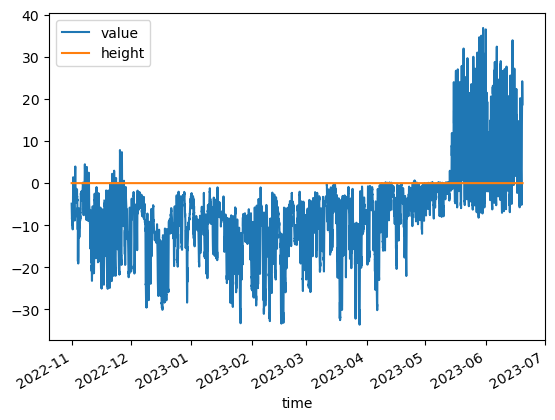

In [43]:
sos_df.query("variable == 'Tsurf_c'").set_index('time').plot()

In [44]:
src = sos_df[sos_df.variable.isin(['Tsurf_c', 'Tsurf_d', 'Tsurf_ue', 'Tsurf_uw'])]
src = src[src.time >= '20230512 ']
src = src[src.time < '20230522']
alt.Chart(src).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q'),
    alt.Color('tower:N')
)

alt.Chart(...)

Check that everything made it into our dataset

<Axes: xlabel='time'>

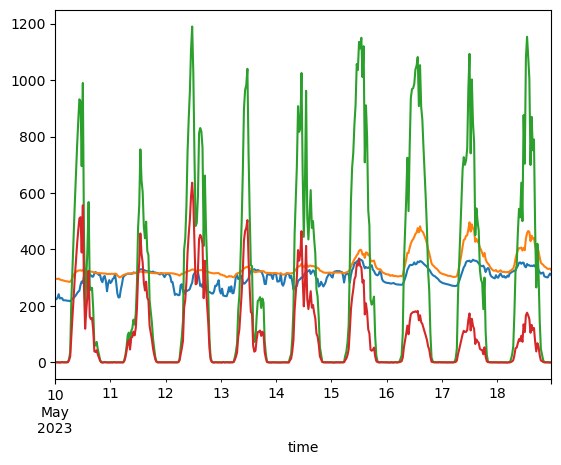

In [45]:
sos_df.query("variable == 'Rlw_in_9m_d'").set_index('time').sort_index().loc['20230510': '20230518'].value.plot()
sos_df.query("variable == 'Rlw_out_9m_d'").set_index('time').sort_index().loc['20230510': '20230518'].value.plot()
sos_df.query("variable == 'Rsw_in_9m_d'").set_index('time').sort_index().loc['20230510': '20230518'].value.plot()
sos_df.query("variable == 'Rsw_out_9m_d'").set_index('time').sort_index().loc['20230510': '20230518'].value.plot()

## Calculate terms

Net radiation

In [46]:
EST_ALBEDO = 0.6
net_rad_df = sos_df[sos_df.variable.isin([
    'Rsw_in_9m_d',
    'Rsw_out_9m_d',
    'Rlw_in_9m_d',
    'Rlw_out_9m_d',
])].pivot_table(index='time', columns='variable', values='value')

net_rad_df['Rsw_out_9m_d_modeled'] = EST_ALBEDO*net_rad_df['Rsw_in_9m_d']

net_rad_df['net radiation'] = (
    net_rad_df['Rsw_in_9m_d'] - net_rad_df['Rsw_out_9m_d_modeled'] 
    + net_rad_df['Rlw_in_9m_d'] - net_rad_df['Rlw_out_9m_d']
)
net_rad_df['albedo'] = net_rad_df['Rsw_out_9m_d_modeled'] / net_rad_df['Rsw_in_9m_d']
# net_rad_df = net_rad_df[['net radiation']]
net_rad_df.head(3)

variable,Rlw_in_9m_d,Rlw_out_9m_d,Rsw_in_9m_d,Rsw_out_9m_d,Rsw_out_9m_d_modeled,net radiation,albedo
time,,,,,,,
2022-10-31 18:00:00,227.488495,302.437836,-4.726302,0.560483,-2.835781,-76.839861,0.6
2022-10-31 18:30:00,225.267212,299.188721,-7.182425,-1.261818,-4.309455,-76.794479,0.6
2022-10-31 19:00:00,224.290741,296.014160,-6.188878,-1.107492,-3.713327,-74.198970,0.6


Turbulent fluxes

In [47]:
turb_flux_df = sos_df[sos_df.variable.isin([
    'w_h2o__3m_c',
    'w_tc__3m_c'
])].pivot_table(index='time', columns='variable', values='value')

latent_heat_sublimation = 2838 #J/g
turb_flux_df['w_h2o__3m_c'] = - turb_flux_df['w_h2o__3m_c'] * latent_heat_sublimation

specific_heat_capacity_air = 1.005 # J/K/g
air_density = 1000 # g/m^3                                       
turb_flux_df['w_tc__3m_c'] = - turb_flux_df['w_tc__3m_c'] * specific_heat_capacity_air * air_density

turb_flux_df.head(3)

variable,w_h2o__3m_c,w_tc__3m_c
time,,
2022-10-31 18:00:00,-7.737561,26.781283
2022-10-31 18:30:00,-8.103559,26.646656
2022-10-31 19:00:00,-5.446743,24.788923


Melt energy, from snow pillows

In [48]:
snowpillow_melt_energy_df = sos_df[sos_df.variable.isin([
    'SWE_p2_c', 'SWE_p4_c', 
    'SWE_p1_c', 'SWE_p3_c', 
])].set_index('time').sort_index().loc[
    '20230510': '20230518'
].reset_index().pivot_table(
    index = ['time', 'tower'],
    values='value',
    columns='measurement'
).reset_index()

# Create a 60min xr dataset
snowpillow_melt_energy_ds = snowpillow_melt_energy_df.set_index(['time', 'tower']).to_xarray()['SWE'].resample(time='60min').mean()

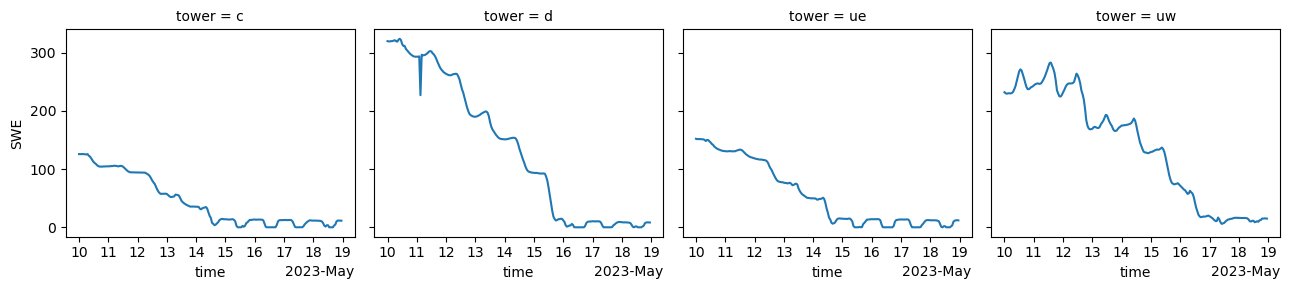

In [49]:
snowpillow_melt_energy_ds.plot(col='tower')

Apply a very loose filter, removing data outside a rolling window of 4x std dev, to remove that one spike 

In [50]:
data = snowpillow_melt_energy_ds.sel(tower = 'd')
# Assuming `data` is a pandas Series or DataFrame column
window_size = 5  # Define the rolling window size

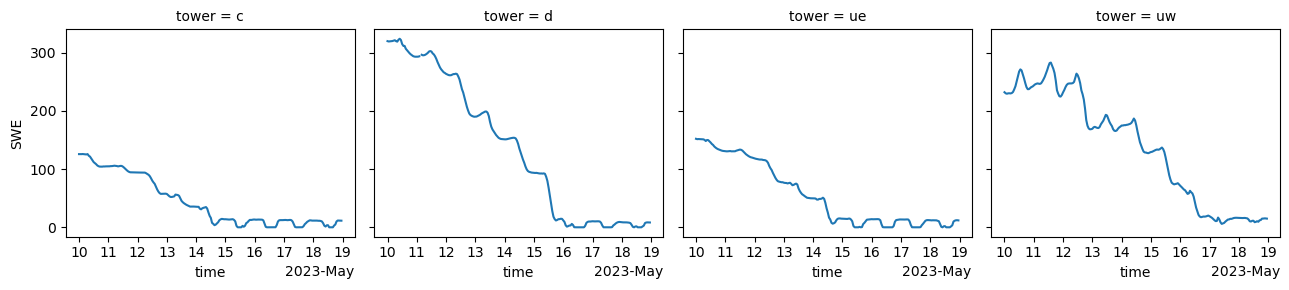

In [51]:
# Calculate rolling mean and standard deviation
rolling_mean = snowpillow_melt_energy_ds.rolling(time=window_size, center=True, min_periods=1).mean()
rolling_std = snowpillow_melt_energy_ds.rolling(time=window_size, center=True, min_periods=1).std()

# Define the bounds
lower_bound = rolling_mean - 1.8 * rolling_std
upper_bound = rolling_mean + 1.8 * rolling_std

# Remove data outside the bounds
filtered_data = snowpillow_melt_energy_ds.where((snowpillow_melt_energy_ds >= lower_bound) & (snowpillow_melt_energy_ds <= upper_bound))

# Display the filtered data
filtered_data.plot(col='tower')

We can see that this removed just a single data point, which we infill

In [52]:
filtered_data.isnull().sum()

<xarray.DataArray 'SWE' ()> Size: 8B
array(1)

In [53]:
snowpillow_melt_energy_ds = filtered_data.ffill('time')

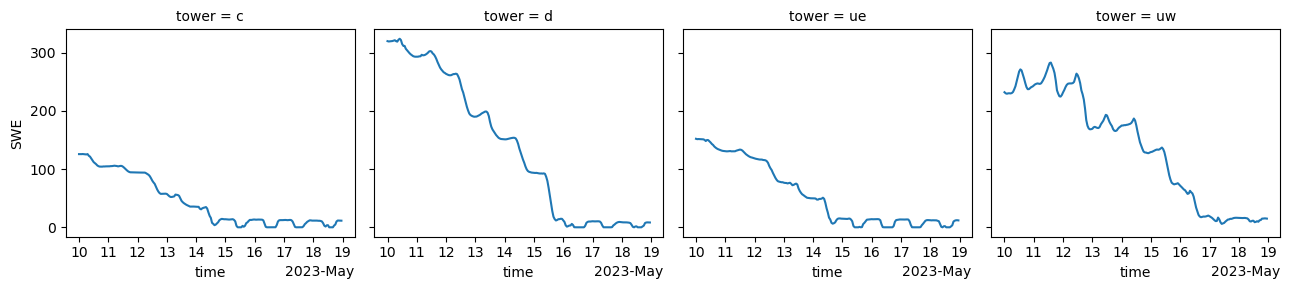

In [54]:
snowpillow_melt_energy_ds.plot(col='tower')

In [55]:
# Perform a cumulative minimum. This filters data, and removes data that represent increases in SWE over time.
snowpillow_melt_energy_filtered_ds = snowpillow_melt_energy_ds.copy(data = np.minimum.accumulate(snowpillow_melt_energy_ds.values))

# calculate mm/hr from 
mm_hr = snowpillow_melt_energy_ds.differentiate('time', datetime_unit = 'h')
mm_hr_filtered = snowpillow_melt_energy_filtered_ds.differentiate('time', datetime_unit = 'h')

Check out the filtered measurements

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_35962/1386982484.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend()


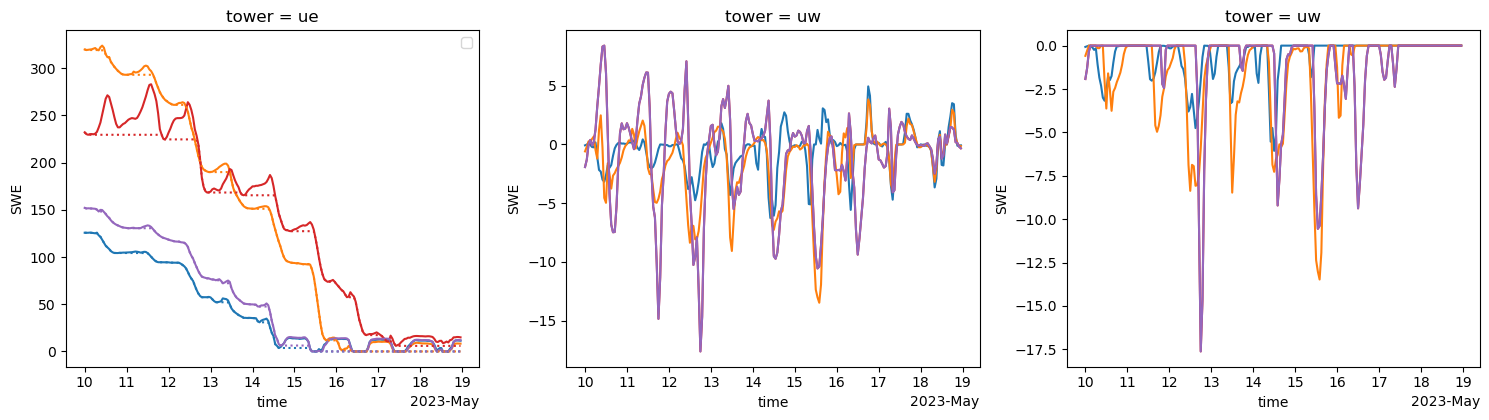

In [56]:
fig, axes = plt.subplots(1,3, figsize=(15,4.3))
snowpillow_melt_energy_ds.sel(tower='c').plot(ax = axes[0], color='tab:blue')
snowpillow_melt_energy_ds.sel(tower='d').plot(ax = axes[0], color='tab:orange')
snowpillow_melt_energy_ds.sel(tower='uw').plot(ax = axes[0], color='tab:red')
snowpillow_melt_energy_ds.sel(tower='ue').plot(ax = axes[0], color='tab:purple')
snowpillow_melt_energy_filtered_ds.sel(tower='c').plot(linestyle=':', ax = axes[0], color='tab:blue')
snowpillow_melt_energy_filtered_ds.sel(tower='d').plot(linestyle=':', ax = axes[0], color='tab:orange')
snowpillow_melt_energy_filtered_ds.sel(tower='uw').plot(linestyle=':', ax = axes[0], color='tab:red')
snowpillow_melt_energy_filtered_ds.sel(tower='ue').plot(linestyle=':', ax = axes[0], color='tab:purple')

mm_hr.sel(tower = 'c').plot(ax = axes[1], color='tab:blue')
mm_hr.sel(tower = 'd').plot(ax = axes[1], color='tab:orange')
mm_hr.sel(tower = 'uw').plot(ax = axes[1], color='tab:red')
mm_hr.sel(tower = 'uw').plot(ax = axes[1], color='tab:purple')

mm_hr_filtered.sel(tower = 'c').plot(ax = axes[2], color='tab:blue')
mm_hr_filtered.sel(tower = 'd').plot(ax = axes[2], color='tab:orange')
mm_hr_filtered.sel(tower = 'uw').plot(ax = axes[2], color='tab:red')
mm_hr_filtered.sel(tower = 'uw').plot(ax = axes[2], color='tab:purple')

axes[0].legend()
plt.tight_layout()

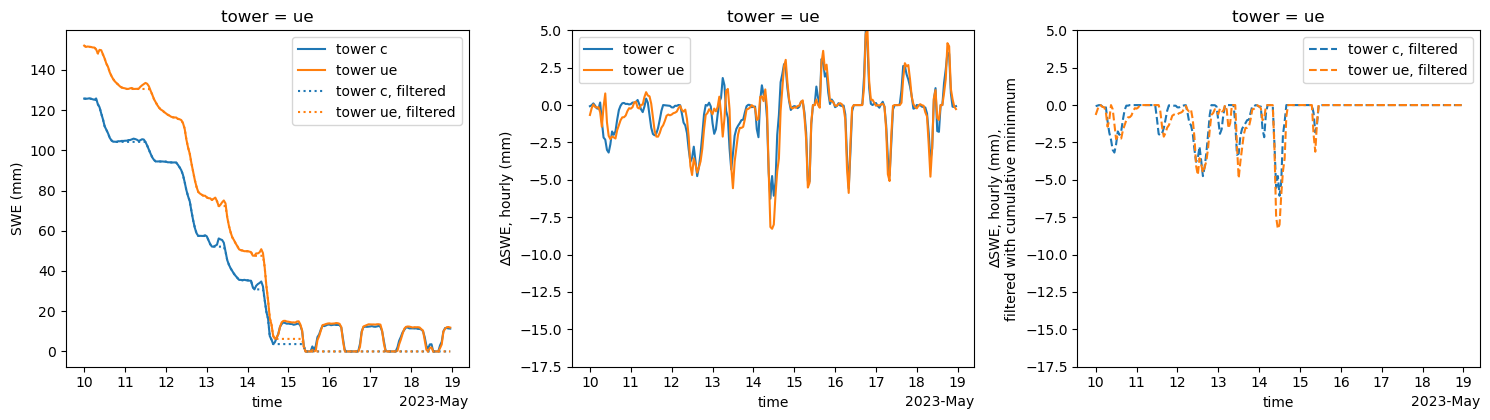

In [57]:
fig, axes = plt.subplots(1,3, figsize=(15,4.3))
snowpillow_melt_energy_ds.sel(tower='c').plot(ax = axes[0], color='tab:blue', label='tower c')
snowpillow_melt_energy_ds.sel(tower='ue').plot(ax = axes[0], color='tab:orange', label='tower ue')
snowpillow_melt_energy_filtered_ds.sel(tower='c').plot(linestyle=':', ax = axes[0], color='tab:blue', label='tower c, filtered')
snowpillow_melt_energy_filtered_ds.sel(tower='ue').plot(linestyle=':', ax = axes[0], color='tab:orange', label='tower ue, filtered')

mm_hr.sel(tower = 'c').plot(ax = axes[1], color='tab:blue', label='tower c')
mm_hr.sel(tower = 'ue').plot(ax = axes[1], color='tab:orange', label='tower ue')

mm_hr_filtered.sel(tower = 'c').plot(ax = axes[2], color='tab:blue', linestyle='--', label='tower c, filtered')
mm_hr_filtered.sel(tower = 'ue').plot(ax = axes[2], color='tab:orange', linestyle='--', label='tower ue, filtered')

axes[0].set_ylabel('SWE (mm)')
axes[1].set_ylabel('∆SWE, hourly (mm)')
axes[2].set_ylabel('∆SWE, hourly (mm),\nfiltered with cumulative mininmum')
axes[1].set_ylim(-17.5, 5)
axes[2].set_ylim(-17.5, 5)
axes[0].legend()
axes[1].legend()
axes[2].legend()
plt.tight_layout()

Convert snow pillow SWE change to W/m^2

In [58]:
snowpillow_melt_energy_df = (
    (
        (
            mm_hr_filtered
        ) * units("mm/hr") * snow_density * specific_heat_of_fusion
    )
).pint.to("W/m^2").rename('melt energy').to_dataframe()

# Compare LIDAR E_melt and Snow Pillow E_melt 

In [59]:
lidar_melt_energy_df = pd.concat([ds.to_dataframe() for ds in emelt_hourly_ds_list]).rename(
    columns = {'surface': 'melt energy'}
)

In [60]:
lidar_src = lidar_melt_energy_df.xs(slice('20230510', '20230518'), level=0, drop_level=False).reset_index()
snowpillow_src = snowpillow_melt_energy_df.xs(slice('20230510', '20230518'), level=0, drop_level=False).reset_index()
alt.Chart(lidar_src).mark_errorbar(extent='iqr').encode(
    alt.X('time:T'),
    alt.Y('melt energy:Q'),
).properties(width=900) + alt.Chart(lidar_src).mark_circle(color='grey').encode(
    alt.X('time:T'),
    alt.Y('median(melt energy):Q'),
).properties(width=900) + alt.Chart(snowpillow_src).mark_line().encode(
    alt.X('time:T'),
    alt.Y('melt energy:Q'),
    alt.Color('tower:N'),
).properties(width=900)

alt.LayerChart(...)

In [61]:
alt.Chart(lidar_src).mark_line().encode(
    alt.X('time:T'),
    alt.Y('melt energy:Q'),
    alt.Color('patch:N').scale(domain=['d_1', 'd_2', 'd_5', 'uw_0', 'uw_1', 'uw_2'], range=['blue', 'blue', 'blue', 'red', 'red', 'red'])
).properties(width=900)

alt.Chart(...)

# Combine all terms

In [62]:
# create dataframes of all the different Emelt estimates, in wide format
lidar_src_wide = lidar_src.pivot_table(index='time', values='melt energy', columns='patch')
lidar_src_wide.columns = [f"Emelt_{col_name}" for col_name in lidar_src_wide.columns]

snowpillow_src_wide = snowpillow_src.pivot_table(index='time', values='melt energy', columns='tower')
snowpillow_src_wide.columns = [f"Emelt_{col_name}" for col_name in snowpillow_src_wide.columns]

In [63]:
display(lidar_src_wide.head(3))
display(snowpillow_src_wide.head(3))
display(turb_flux_df.head(3))
display(net_rad_df.head(3))

,Emelt_d_1,Emelt_d_2,Emelt_d_5,Emelt_uw_0,Emelt_uw_1,Emelt_uw_2
time,,,,,,
2023-05-10 00:00:00,-86.558703,-71.108302,-243.454606,-247.650172,-368.368865,-288.520528
2023-05-10 01:00:00,-55.997333,-50.535528,-197.166679,-189.850538,-251.601188,-213.251029
2023-05-10 02:00:00,-24.973269,-20.164982,-103.371754,-78.340963,-83.177899,-86.633994


,Emelt_c,Emelt_d,Emelt_ue,Emelt_uw
time,,,,
2023-05-10 00:00:00,-2.739759,-21.845022,-24.504795,-71.388887
2023-05-10 01:00:00,-1.369879,-10.922511,-12.252397,-48.284763
2023-05-10 02:00:00,0.000000,0.000000,0.000000,-12.590319


variable,w_h2o__3m_c,w_tc__3m_c
time,,
2022-10-31 18:00:00,-7.737561,26.781283
2022-10-31 18:30:00,-8.103559,26.646656
2022-10-31 19:00:00,-5.446743,24.788923


variable,Rlw_in_9m_d,Rlw_out_9m_d,Rsw_in_9m_d,Rsw_out_9m_d,Rsw_out_9m_d_modeled,net radiation,albedo
time,,,,,,,
2022-10-31 18:00:00,227.488495,302.437836,-4.726302,0.560483,-2.835781,-76.839861,0.6
2022-10-31 18:30:00,225.267212,299.188721,-7.182425,-1.261818,-4.309455,-76.794479,0.6
2022-10-31 19:00:00,224.290741,296.014160,-6.188878,-1.107492,-3.713327,-74.198970,0.6


In [64]:
energy_balance_df = lidar_src_wide.join(
    snowpillow_src_wide
).join(
    turb_flux_df.resample('60min').mean()    
).join(
    net_rad_df.resample('60min').mean()['net radiation']
)


# Plot

In [65]:
energy_balance_df['Emelt_lidar_median'] = energy_balance_df[[
        'Emelt_d_1', 'Emelt_d_2', 'Emelt_d_5', 'Emelt_uw_0', 'Emelt_uw_1', 'Emelt_uw_2', 
]].median(axis=1)

In [66]:
# energy_balance_df['residual'] = energy_balance_df[[
#         'Emelt_lidar_median', 'net radiation', 'w_h2o__3m_c',
# ]].sum(axis=1)
energy_balance_df['residual_d_1'] = - energy_balance_df[['Emelt_d_1', 'net radiation', 'w_h2o__3m_c',       'w_tc__3m_c']].sum(axis=1)
energy_balance_df['residual_d_2'] = - energy_balance_df[['Emelt_d_2', 'net radiation', 'w_h2o__3m_c',       'w_tc__3m_c']].sum(axis=1)
energy_balance_df['residual_d_5'] = - energy_balance_df[['Emelt_d_5', 'net radiation', 'w_h2o__3m_c',       'w_tc__3m_c']].sum(axis=1)
energy_balance_df['residual_uw_0'] =    - energy_balance_df[['Emelt_uw_0', 'net radiation', 'w_h2o__3m_c',  'w_tc__3m_c']].sum(axis=1)
energy_balance_df['residual_uw_1'] =    - energy_balance_df[['Emelt_uw_1', 'net radiation', 'w_h2o__3m_c',  'w_tc__3m_c']].sum(axis=1)
energy_balance_df['residual_uw_2'] =    - energy_balance_df[['Emelt_uw_2', 'net radiation', 'w_h2o__3m_c',  'w_tc__3m_c']].sum(axis=1)

In [67]:
residual_band_chart = alt.Chart(
    energy_balance_df.reset_index()
).transform_fold([
    'residual_d_1', 'residual_d_2', 'residual_d_5', 'residual_uw_0', 'residual_uw_1', 'residual_uw_2'
]).mark_errorband(extent='iqr', color='grey', borders={'color':'lightgrey', 'strokeWidth': 1}).encode(
    alt.X('time:T'),
    alt.Y('value:Q'),
).properties(width=900)
rad_and_turb_fluxes = alt.Chart(
    energy_balance_df.reset_index()
).transform_fold([
    'net radiation', 'w_h2o__3m_c', 'w_tc__3m_c',
]).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q'),
    alt.Color('key:N'),
).properties(width=900)
e_melt_median_chart = alt.Chart(
    energy_balance_df.reset_index()
).mark_circle(color='black').encode(
    alt.X('time:T'),
    alt.Y('Emelt_lidar_median:Q'),
).properties(width=900)
e_melt_spread_chart = alt.Chart(
    energy_balance_df.reset_index()
).transform_fold([
    'Emelt_d_1', 'Emelt_d_2', 'Emelt_d_5', 'Emelt_uw_0', 'Emelt_uw_1', 'Emelt_uw_2', 
]).mark_errorbar(extent='iqr').encode(
    alt.X('time:T'),
    alt.Y('value:Q'),
).properties(width=900)
 
e_balance_chart = (
    residual_band_chart + e_melt_spread_chart + e_melt_median_chart + rad_and_turb_fluxes
)

In [68]:
e_balance_chart

alt.LayerChart(...)

# Examine EC flux divergence

In [69]:
from metpy.units import units
def w_tc_to_watts(values):
    specific_heat_capacity_air = 1.0005 * units('kilojoules/(K*kg)')
    air_density = 1 * units("kg/m^3")
    sensible_heat_flux_meas_units = values * units("K*m/s")
    return (sensible_heat_flux_meas_units * specific_heat_capacity_air * air_density).to("W/m^2").magnitude
def w_h2o_to_watts(values):
    latent_heat_of_vaporization = 2838 * units("J/g")
    latent_heat_flux_meas_units = values * units("g/(m^2 * s)")
    return (latent_heat_flux_meas_units * latent_heat_of_vaporization).to("W/m^2").magnitude

In [70]:
zero_line = alt.Chart().mark_rule(color='black', strokeDash=[5, 5]).encode(
    y=alt.datum(0)  # Set y=0
).transform_calculate(
    x='datum.x'  # Use a placeholder for x if needed
)

In [81]:
src = sos_df[sos_df.variable.isin([
    'w_tc__3m_c',
    'w_tc__3m_ue', 
    'w_tc__3m_uw', 
    'w_tc__3m_d', 
])]
src = src[src.time > '20230510']
src = src[src.time < '20230524']
# src = src.query("tower == 'c'")
src.value = w_tc_to_watts(src.value.values)
w_tc_chart = alt.Chart(src).transform_window(
    rolling_avg = 'mean(value)',
    frame=[-2,2],
    groupby = ['tower', 'height'],
).mark_line().encode(
    alt.X('time:T').axis(format='May %d %H00'),
    alt.Y('rolling_avg:Q'),
    alt.Color('height:N'),
    alt.StrokeDash('tower:N'),
).properties(width=900) + zero_line
w_tc_chart.interactive()

alt.LayerChart(...)

In [86]:
src = sos_df[sos_df.variable.isin([
    'w_tc__1m_c', 'w_tc__2m_c', 'w_tc__3m_c', 'w_tc__5m_c', 'w_tc__10m_c', 'w_tc__15m_c', 'w_tc__20m_c', 
    'w_tc__1m_ue', 'w_tc__2m_ue', 'w_tc__3m_ue', 
    'w_tc__1m_uw', 'w_tc__2m_uw', 'w_tc__3m_uw', 
    'w_tc__1m_d', 'w_tc__2m_d', 'w_tc__3m_d', 
])]
src = src[src.time > '20230510']
src = src[src.time < '20230524']
# src = src.query("tower == 'c'")
src.value = w_tc_to_watts(src.value.values)
w_tc_chart = alt.Chart(src).transform_window(
    rolling_avg = 'mean(value)',
    frame=[-2,2],
    groupby = ['tower', 'height'],
).mark_line().encode(
    alt.X('time:T').axis(format='May %d %H00'),
    alt.Y('rolling_avg:Q'),
    alt.Color('height:N'),
    alt.StrokeDash('tower:N'),
).properties(width=900) + zero_line
w_tc_chart.interactive()

alt.LayerChart(...)

In [72]:
src = sos_df[sos_df.variable.isin([
    'w_h2o__1m_c', 'w_h2o__2m_c', 'w_h2o__3m_c', 'w_h2o__5m_c', 
    # 'w_h2o__1m_ue', 'w_h2o__2m_ue', 'w_h2o__3m_ue', 
    # 'w_h2o__1m_uw', 'w_h2o__2m_uw', 'w_h2o__3m_uw', 
    # 'w_h2o__1m_d', 'w_h2o__2m_d', 'w_h2o__3m_d', 
])]
src = src[src.time > '20230510']
src = src[src.time < '20230524']
src = src.query("tower == 'c'")
src.value = w_h2o_to_watts(src.value.values)
w_h2o_chart = alt.Chart(src).transform_window(
    rolling_avg = 'mean(value)',
    frame=[-2,2],
    groupby = ['tower', 'height'],
).mark_line().encode(
    alt.X('time:T').axis(format='May %d %H00'),
    alt.Y('rolling_avg:Q'),
    alt.Color('height:N'),
    alt.StrokeDash('tower:N'),
).properties(width=900) + zero_line
w_h2o_chart

alt.LayerChart(...)

In [73]:
src = sos_df[sos_df.variable.isin([
    'w_h2o__2m_c',
    'w_h2o__2m_d',
    'w_h2o__2m_ue',
    'w_h2o__2m_uw',
])]
src = src[src.time > '20230510']
src = src[src.time < '20230524']
src.value = w_h2o_to_watts(src.value.values)
w_h2o_chart = alt.Chart(src).transform_window(
    rolling_avg = 'mean(value)',
    frame=[-2,2],
    groupby = ['tower', 'height'],
).mark_line().encode(
    alt.X('time:T').axis(format='May %d %H00'),
    alt.Y('rolling_avg:Q'),
    # alt.Color('height:N'),
    alt.StrokeDash('tower:N'),
).properties(width=900) + zero_line
w_h2o_chart

alt.LayerChart(...)

In [74]:
src = sos_df[sos_df.variable.isin([
    'spd_2m_c',
    'T_2m_c',
])]
src = src[src.time > '20230510']
src = src[src.time < '20230524']
w_h2o_chart = alt.Chart(src).transform_window(
    rolling_avg = 'mean(value)',
    frame=[-4,4],
    groupby = ['tower', 'height', 'variable'],
).mark_line().encode(
    alt.X('time:T').axis(format='May %d %H00'),
    alt.Y('value:Q'),
    alt.Color('variable:N'),
    alt.StrokeDash('tower:N'),
).properties(width=1200) + zero_line
w_h2o_chart

alt.LayerChart(...)

In [75]:
src = sos_df[sos_df.variable.isin([
    'Tsurf_c',
    'Tsurf_d',
    'Tsurf_ue',
    'Tsurf_uw',
])]
src = src[src.time > '20230510']
src = src[src.time < '20230524']
w_h2o_chart = alt.Chart(src).transform_window(
    rolling_avg = 'mean(value)',
    frame=[-2,2],
    groupby = ['tower', 'height'],
).mark_line().encode(
    alt.X('time:T').axis(format='May %d %H00'),
    alt.Y('rolling_avg:Q'),
    # alt.Color('height:N'),
    alt.StrokeDash('tower:N'),
).properties(width=900) + zero_line
w_h2o_chart

alt.LayerChart(...)

In [87]:
wind_dir_src = sos_df[sos_df.variable.isin([
    'dir_3m_c',
])]
wind_dir_src = wind_dir_src[wind_dir_src.time > '20230510']
wind_dir_src = wind_dir_src[wind_dir_src.time < '20230518']
wind_dir_chart = alt.Chart(wind_dir_src).mark_circle().encode(
    alt.X('time:T').axis(format='May %d %H00'),
    alt.Y('value:Q'),
    alt.Color('height:N'),
).properties(width=900) + zero_line
wind_dir_chart.interactive()

alt.LayerChart(...)

In [77]:
n_downvalley_winds = len(wind_dir_src[(wind_dir_src.value > 270) | (wind_dir_src.value < 0)])
n_upvalley_winds = len(wind_dir_src) - n_downvalley_winds
n_total = len(wind_dir_src)
print(round(100*n_downvalley_winds/n_total))
print(round(100*n_upvalley_winds/n_total))

73
27


In [98]:
src = sos_df[sos_df.variable.isin([
    'Tsurf_c',
    'Tsurf_d',
    'Tsurf_ue',
    'Tsurf_uw',
])]
alt.Chart(
    src[src.time >= '20230510'][src.time < '20230519'].query("tower == 'uw'")
).transform_window(
    rolling_avg = 'mean(value)',
    frame=[-2,2],
    groupby = ['tower', 'height'],
).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q'),
    alt.Color('tower:N'),
    # alt.StrokeDash('tower:N'),
).properties(width=900)

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_35402/1283919191.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  src[src.time >= '20230510'][src.time < '20230519'].query("tower == 'uw'")


alt.Chart(...)

We observe that one average, between 0600 and 1200, surface temps increase 5˚C

In [99]:
delta_T_delta_t = 5*units("kelvin") / (6*60*60 * units("seconds"))

c_p of ice is ~2100
c_p of snow is ~1005

So a c_p in between the two is probably a fine estimate

In [100]:
c_p = 1552 * units('joules/(kelvin*kg)')
rho = 400 * units("kg/m^3")

In [101]:
snow_depth = 50 #cm

In [102]:
(delta_T_delta_t * (snow_depth * units('cm'))*rho*c_p).to(units("W/m^2"))

<Quantity(71.85185185185185, 'watt / meter ** 2')>

Let's calculate the storage change term forreal 

In [103]:
rolling_surf_t = sos_df.query("variable == 'Tsurf_uw'").set_index('time').loc['20230509':'20230518'].value.rolling(10, center=True).mean()
dT_dt = rolling_surf_t.to_xarray().differentiate('time', datetime_unit = 's')
dT_dt.values * units("kelvin/second")

snow_depth = 50 #cm
storage_change_term_w_units = ((dT_dt.values * units("kelvin/second")) * (snow_depth * units('cm'))*rho*c_p).to(units("W/m^2"))
storage_change = dT_dt.copy(data = storage_change_term_w_units)

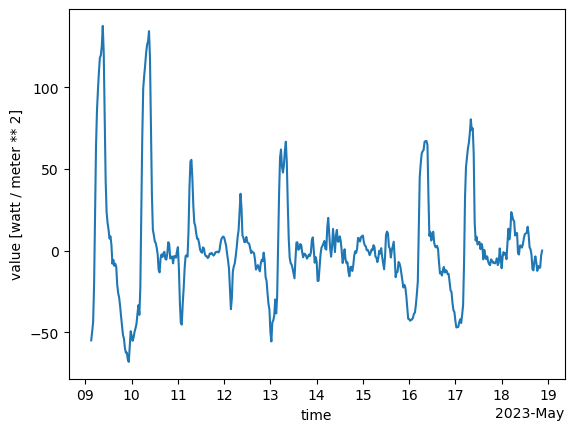

In [104]:
storage_change.plot()

In [105]:
residual_band_chart = alt.Chart(
    energy_balance_df.reset_index()
).transform_fold([
    'residual_d_1', 'residual_d_2', 'residual_d_5', 'residual_uw_0', 'residual_uw_1', 'residual_uw_2'
]).mark_errorband(extent='iqr', color='grey', borders={'color':'lightgrey', 'strokeWidth': 1}).encode(
    alt.X('time:T'),
    alt.Y('value:Q'),
).properties(width=900)
rad_and_turb_fluxes = alt.Chart(
    energy_balance_df.reset_index()
).transform_fold([
    'net radiation', 'w_h2o__3m_c', 'w_tc__3m_c',
]).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q'),
    alt.Color('key:N'),
).properties(width=900)
e_melt_median_chart = alt.Chart(
    energy_balance_df.reset_index()
).mark_circle(color='black').encode(
    alt.X('time:T'),
    alt.Y('Emelt_lidar_median:Q'),
).properties(width=900)
e_melt_spread_chart = alt.Chart(
    energy_balance_df.reset_index()
).transform_fold([
    'Emelt_d_1', 'Emelt_d_2', 'Emelt_d_5', 'Emelt_uw_0', 'Emelt_uw_1', 'Emelt_uw_2', 
]).mark_errorbar(extent='iqr').encode(
    alt.X('time:T'),
    alt.Y('value:Q'),
).properties(width=900)
 
e_balance_chart = (
    residual_band_chart + e_melt_spread_chart + e_melt_median_chart + rad_and_turb_fluxes
)

In [106]:
e_balance_chart

alt.LayerChart(...)